# Getting Treatment

### by Kaitlyn Keil
### March 2017

<a href = http://www.icpsr.umich.edu/icpsrweb/ICPSR/series/64>Link to NSDUH Website</a>

<a href = http://www.icpsr.umich.edu/icpsrweb/ICPSR/ssvd/studies/36361/variables>Variable list link</a>

<a href = https://github.com/KaitlynKeil/ThinkStats2/blob/master/code/reports/report2.md>Corresponding Article</a>

In [16]:
""" This file contains code used to analyze the
2014 NSDUH Survey, the information for which can be found at this link:
http://www.icpsr.umich.edu/icpsrweb/ICPSR/series/64

The following packages are required to run this code.
"""

from __future__ import print_function, division
import pandas as pd

import sys
import numpy as np
import thinkstats2
import thinkplot
import matplotlib.pyplot as plt
from operator import itemgetter
from cycler import cycler

from collections import defaultdict, Counter
import survival
import statsmodels.formula.api as smf

In [2]:
def ReadNSDUH():
    """ Reads the NSDUH file.

    returns a Dataframe
    """
    nsduh = pd.read_stata('reports/report2data/ICPSR_36361/DS0001/36361-0001-Data.dta',convert_categoricals=False, convert_missing=False)
    return nsduh

#Row-wise minimum: check pandas, otherwise convert to NP array, check min over an axis, assign to new column
#  min(axis=1)

In [3]:
def CleanData(df):
    """ Replaces the error codes for the necessary values.
    Due to the high number of variables in the survey,
    only the ones I intend to use are cleaned.
    Creates several new columns:
    
    alcProb: 1 if resp has an alcohol problem, 0 otherwise
    dui: 1 if resp has driven under intoxication
    ageTX: age at time of treatment
    yearssincefirst: number of years since their first treatment
    yearsbeforeTX: years of alcohol use before first treatment
    treated: 1 if resp has been through treatment, 0 otherwise
    age: recalculated age
    zeros: column of zeros for later use
    """
    na_vals = range(981,1000)#[981 , 989 , 991 , 994 , 997 , 998 , 999]
    ev_vals = []
    df.TXALONAG.replace(na_vals, np.nan, inplace=True)
    df.IRALCAGE.replace(na_vals, np.nan, inplace=True)
    df.TXALCDAG.replace(na_vals, np.nan, inplace=True)
    df.TXYALAGE.replace(na_vals, np.nan, inplace=True)
    df.TXYALDRG.replace(na_vals, np.nan, inplace=True)
    df.TXYALDAG.replace(na_vals, np.nan, inplace=True)
    df.TXYADAAG.replace(na_vals, np.nan, inplace=True)
    df.TXYADDAG.replace(na_vals, np.nan, inplace=True)
    df.DEPNDALC.replace(na_vals, np.nan, inplace=True)
    df.TXALCDEV.replace(na_vals, np.nan, inplace=True)
    df.ABUSEALC.replace(na_vals, np.nan, inplace=True)
    df.COLLENR.replace([-9], np.nan, inplace=True)
        
    year_nas = [9985, 9989, 9991, 9994, 9997, 9998, 9999]
    df.IRALCYFU.replace(year_nas, np.nan, inplace=True)
    
    tx_temp = df.loc[:,['TXALONAG','TXALCDAG','TXYALAGE',
                 'TXYALDAG','TXYADAAG','TXYADDAG']]
    
    df['alcProb'] = ((df.DEPNDALC==1) | (df.ABUSEALC==1)).astype(int)
    df['dui'] = ((df.DRIVALC2==1)|(df.DRIVALD2==1)).astype(int)
    
    df['ageTX']=tx_temp.min(axis = 1)
    df['yearssincefirst']=2014-df.IRALCYFU
    df['yearsbeforeTX']=df.ageTX - df.IRALCAGE
    df["treated"] = ((df.TXALONEV==1)|(df.TXALCDEV==1)|(df.TXYREVER==1)|(df.TXYREVER==11)).astype(int)
    df["age"] = df.yearssincefirst+df.IRALCAGE
    df['zeros'] = 0

In [4]:
def FillMissing(years_use):
    """Fills missing values with an exponentially weighted moving average.

    years_use: DataFrame of ages
    
    returns: DataFrame with filled missing values for ages
    """
    #ids = pd.years_range(years_use.index.min(), years_use.index.max())
    #reindexed = years_use.reindex(ids)
    
    fake_data = years_use.zeros + thinkstats2.Resample(years_use.age, len(years_use))
    years_use.age.fillna(fake_data, inplace=True)
    
    return years_use

def FillMissingComplete(years_use):
    """Fills missing values with an exponentially weighted moving average.

    years_use: DataFrame of ages at time of treatment
    
    returns: DataFrame with filled missing values for time of treatment
    """
    #ids = pd.years_range(years_use.index.min(), years_use.index.max())
    #reindexed = years_use.reindex(ids)

    fake_data = years_use.zeros + thinkstats2.Resample(years_use.ageTX, len(years_use))
    years_use.ageTX.fillna(fake_data, inplace=True)
    
    return years_use

In [5]:
def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

In [6]:
# Read and clean the data
nsduh = ReadNSDUH()
CleanData(nsduh)

In [7]:
### Break the data into those who have completed treatment and those who are still struggling with alcohol use

complete = FillMissingComplete(nsduh[nsduh.treated== 1])
ongoing = FillMissing(nsduh[nsduh.alcProb==1])
cdf = thinkstats2.Cdf(complete.ageTX)

/home/kaitlyn/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


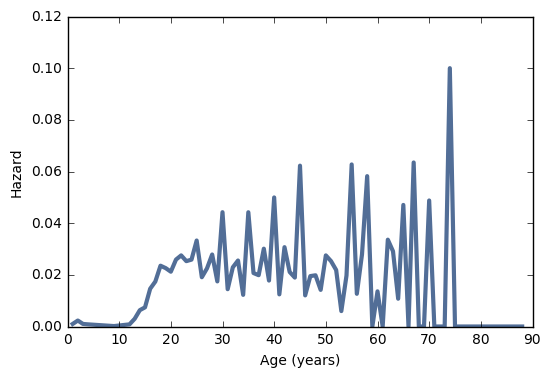

In [12]:
### Find the hazard curve in order to estimate the survival function

hf = EstimateHazardFunction(complete.ageTX.dropna(), ongoing.age.dropna())
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')
thinkplot.Show()

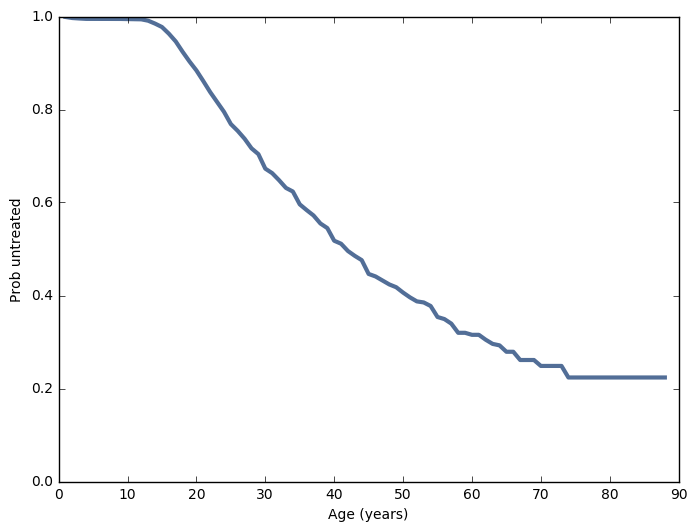

In [15]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob untreated',
                 ylim=[0, 1])
thinkplot.Show()

In [10]:
# Find the percentage of people who have had an alcohol dependency or abused alcohol
#  in the last year and have gotten treatment

hist_treatment = thinkstats2.Hist(nsduh[nsduh.alcProb==1].treated)
# 1 indicates receiving treatment, 2 indicates never having received treatment
print((hist_treatment[1]/(hist_treatment[1]+hist_treatment[0]))*100)

16.6666666667


In [26]:
def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

# Define functions to plot the different survival curves for each income group.
# POVERTY2
#  1 indicates below poverty line (pl)
#  2 indicates up to 2pl income
#  3 indicates >2pl income

def AddLabelsByIncome(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    labels = {1:'Below Poverty Line', 2:'Middle Income', 3:'Double and Above', -9:'College Student'}
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        thinkplot.Plot([15], [1], label=labels[name], **options)

In [27]:
def GetGroupSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = FillMissingComplete(resp[resp.treated== 1])
    ongoing = FillMissing(resp[resp.alcProb==1])
    hf = EstimateHazardFunction(complete.ageTX.dropna(), ongoing.age.dropna())
    sf = hf.MakeSurvival()
    return hf, sf
    

def PlotPredictionsByIncome(groups, **options):
    """Groups respondents by income and plots survival curves.

    groups: GroupBy object
    """
    sfs = []
    for _, group in groups:
        hf, sf = GetGroupSurvival2(group)
        sfs.append(sf)

    thinkplot.PrePlot(len(sfs))
    for i, sf in enumerate(sfs):
        thinkplot.Plot(sf, **options)

/home/kaitlyn/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


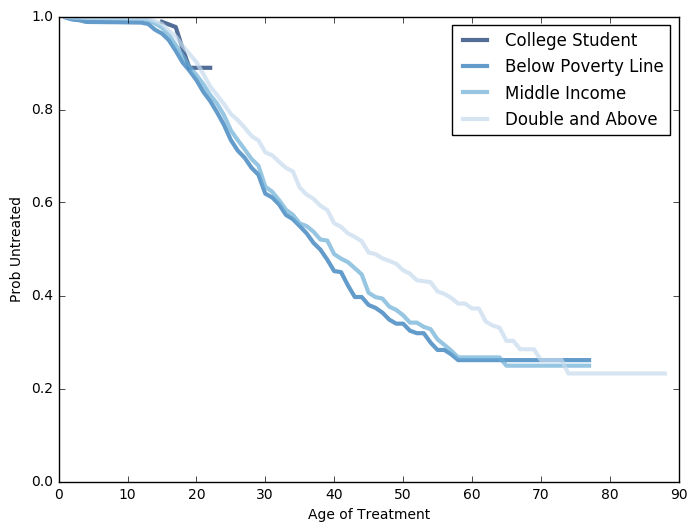

In [28]:
groups = nsduh.groupby('POVERTY2')
PlotPredictionsByIncome(groups)

AddLabelsByIncome(groups, alpha=0.7)
thinkplot.Config(xlabel='Age of Treatment',
                 #xlim = [0, 60],
                 ylabel='Prob Untreated',
                 ylim=[0, 1])
thinkplot.Show()

/home/kaitlyn/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


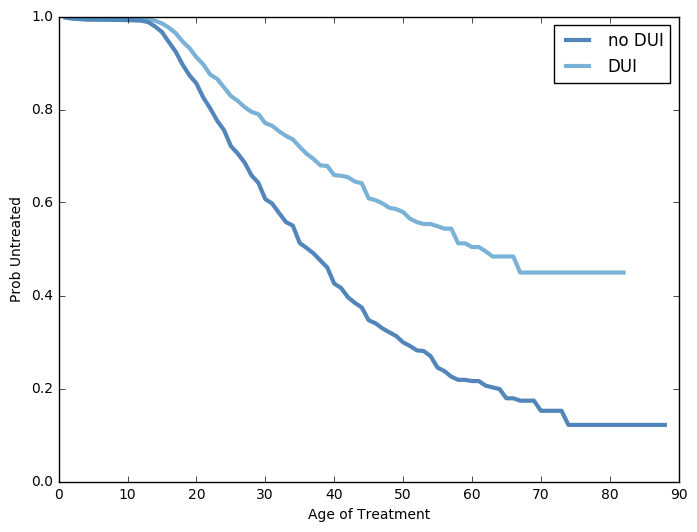

In [29]:
# Split the groups up by whether or not they have driven under the influence.

groups = nsduh.groupby('dui')
PlotPredictionsByIncome(groups)

labels = {0:'no DUI', 1:'DUI'}
thinkplot.PrePlot(len(groups))
for name, _ in groups:
    thinkplot.Plot([15], [1], label=labels[name])
thinkplot.Config(xlabel='Age of Treatment',
                 #xlim = [0, 60],
                 ylabel='Prob Untreated',
                 ylim=[0, 1])
thinkplot.Show()

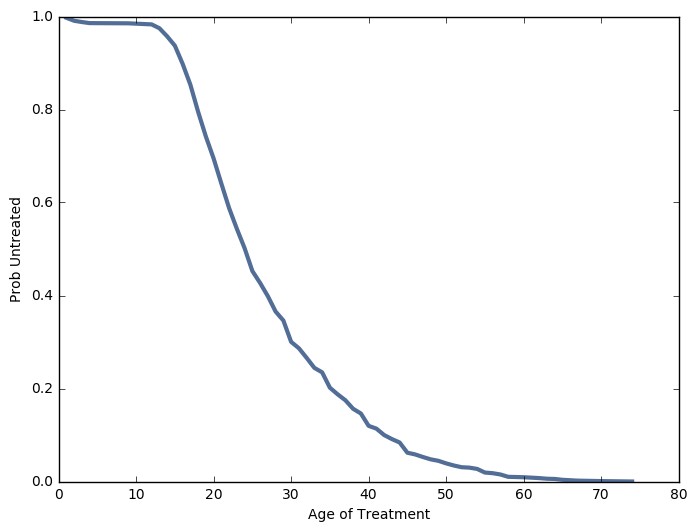

In [30]:
# Plot the survival curve for those who have received treatment for their alcohol use.

sf = MakeSurvivalFromCdf(cdf)
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age of Treatment',
                 ylabel='Prob Untreated')
thinkplot.Show()

In [32]:
# Probability of those treated that they will have been treated by age 18

cdf[18]

0.20495185694635487

In [110]:
# Picking out a few of the interesting ones, we see that dui (respondant has driven while under the influence)
#  has a positive coefficient, suggesting that those who have driven under the influence are more likely to have
#  gotten treatment.

formula = 'treated ~ age + NEWRACE2 + POVERTY2 + IRSEX + dui'

model = smf.logit(formula, data=nsduh)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.203418
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                40694
Model:                          Logit   Df Residuals:                    40688
Method:                           MLE   Df Model:                            5
Date:                Sat, 25 Mar 2017   Pseudo R-squ.:                 0.03789
Time:                        11:35:30   Log-Likelihood:                -8277.9
converged:                       True   LL-Null:                       -8603.9
                                        LLR p-value:                1.127e-138
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.0788      0.095    -21.862      0.000        -2.265    -1.892
age            0.0094      0.001      6.985      0.000         0.007     0.012
NEWRACE2      -0.0525      0.011     -4.903      0.000        -0.073    -0.031
POVERTY2      -0.0723      0.013     -5.564      0.000        -0.098    -0.047
IRSEX         -0.7124      0.046    -15.358      0.000        -0.803    -0.621
dui            0.8463      0.050     17.089      0.000         0.749     0.943
==============================================================================
"""

In [75]:
# IRALCAGE, or the age at which the person first used alcohol, has a negative coefficient and a stronger R^2
#  value. This suggests that those who started drinking younger are more likely to receive treatment.

formula = 'treated ~ age + NEWRACE2 + POVERTY2 + IRSEX + IRALCAGE'

model = smf.logit(formula, data=complete)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.196419
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                40694
Model:                          Logit   Df Residuals:                    40688
Method:                           MLE   Df Model:                            5
Date:                Sat, 25 Mar 2017   Pseudo R-squ.:                 0.07100
Time:                        08:51:12   Log-Likelihood:                -7993.1
converged:                       True   LL-Null:                       -8603.9
                                        LLR p-value:                5.918e-262
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6548      0.121      5.426      0.000         0.418     0.891
age            0.0134      0.001     10.035      0.000         0.011     0.016
NEWRACE2      -0.0496      0.011     -4.612      0.000        -0.071    -0.029
POVERTY2      -0.0807      0.013     -5.982      0.000        -0.107    -0.054
IRSEX         -0.6257      0.047    -13.356      0.000        -0.718    -0.534
IRALCAGE      -0.1796      0.006    -28.857      0.000        -0.192    -0.167
==============================================================================
"""

In [78]:
# Returning to our income brackets, we see that, once again and as we observed, those in poverty are actually
#  more likely to receive treatment (lower numbers tie to low income, and the coefficient is negative).
#  However, this effect is much smaller (seen by the pseudo R^2 value) than the two previous variables.

formula = 'treated ~ POVERTY2'

model = smf.logit(formula, data=nsduh)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.169531
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                55271
Model:                          Logit   Df Residuals:                    55269
Method:                           MLE   Df Model:                            1
Date:                Sat, 25 Mar 2017   Pseudo R-squ.:               0.0001729
Time:                        08:53:37   Log-Likelihood:                -9370.1
converged:                       True   LL-Null:                       -9371.7
                                        LLR p-value:                   0.07186
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.1043      0.039    -80.034      0.000        -3.180    -3.028
POVERTY2      -0.0269      0.014     -1.857      0.063        -0.055     0.001
==============================================================================
"""